### Init

In [1]:
from dotenv import load_dotenv
import sys, os 
sys.path.append('../')
from lib.seed import seed_prefix 
load_dotenv()

seed_prefix(seed = 42)

Seed Fix: 42


### [1]-[2]

In [2]:
from lib.dataset import data_split
import pandas as pd 
data_df = pd.read_csv(os.getenv('DATASHEET_PATH'))
data_dir = os.getenv('DATA_DIR')
train_df, test_df = data_split(data_df, split_num = 5)
train_df, valid_df = data_split(train_df, split_num = 5)



In [3]:
from lib.dataset import PCOS_Dataset
import torchvision.transforms as T
from torchvision.transforms import v2

binary_use = True
train_dataset = PCOS_Dataset(
    data_filenames = train_df['filename'],
    data_dir_path  = data_dir,
    labels         = train_df['label|0:양성, 1:중간형, 2:악성'],
    binary_use = binary_use,
    transform = v2.Compose([
        v2.Resize((296, 296)), # 먼저 296x296으로 Resize
        # v2.CenterCrop(224),           # 224x224 중앙 자르기 -> 0.7977
        v2.RandomResizedCrop(224),           # 224x224 렌담 중앙 자르기 -> 0.8089
        # Augmenttation 추가
        # RandomEqualize(p=0.5),    # Histogram Equalized
        v2.RandomRotation(degrees = 15), # 랜덤 회전
        v2.RandomHorizontalFlip(p = 0.5),    # 랜덤 수평 뒤집기
        v2.RandomVerticalFlip(p = 0.5), # 랜덤 수직 뒤집기
        # Default Augmentation
        v2.Grayscale(num_output_channels=3),  # 3채널 회색변환 (RGB 형태 유지)
        v2.ToTensor(),                # 텐서 변환 
        v2.RandomApply([v2.GaussianNoise(mean = 0, sigma = 0.1, clip = True)], p=0.5), # 가우시안 노이즈
        # v2.RandomApply([v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))], p=0.5), # 가우시안 Blur
        # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 정규화 -> 0.7119
    ])
)

valid_dataset = PCOS_Dataset(
    data_filenames = valid_df['filename'],
    data_dir_path  = data_dir,
    labels         = valid_df['label|0:양성, 1:중간형, 2:악성'],
    binary_use = binary_use,
    transform = T.Compose([
        T.Resize((224, 224)),        # 검증 시에는 224로만 Resize (예시)
        T.Grayscale(num_output_channels=3),
        T.ToTensor(),
    ])
)



[Alert] Sample Dataset Use : False
[Alert] Sample Dataset Use : False


/home/eiden/miniconda3/envs/cv/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


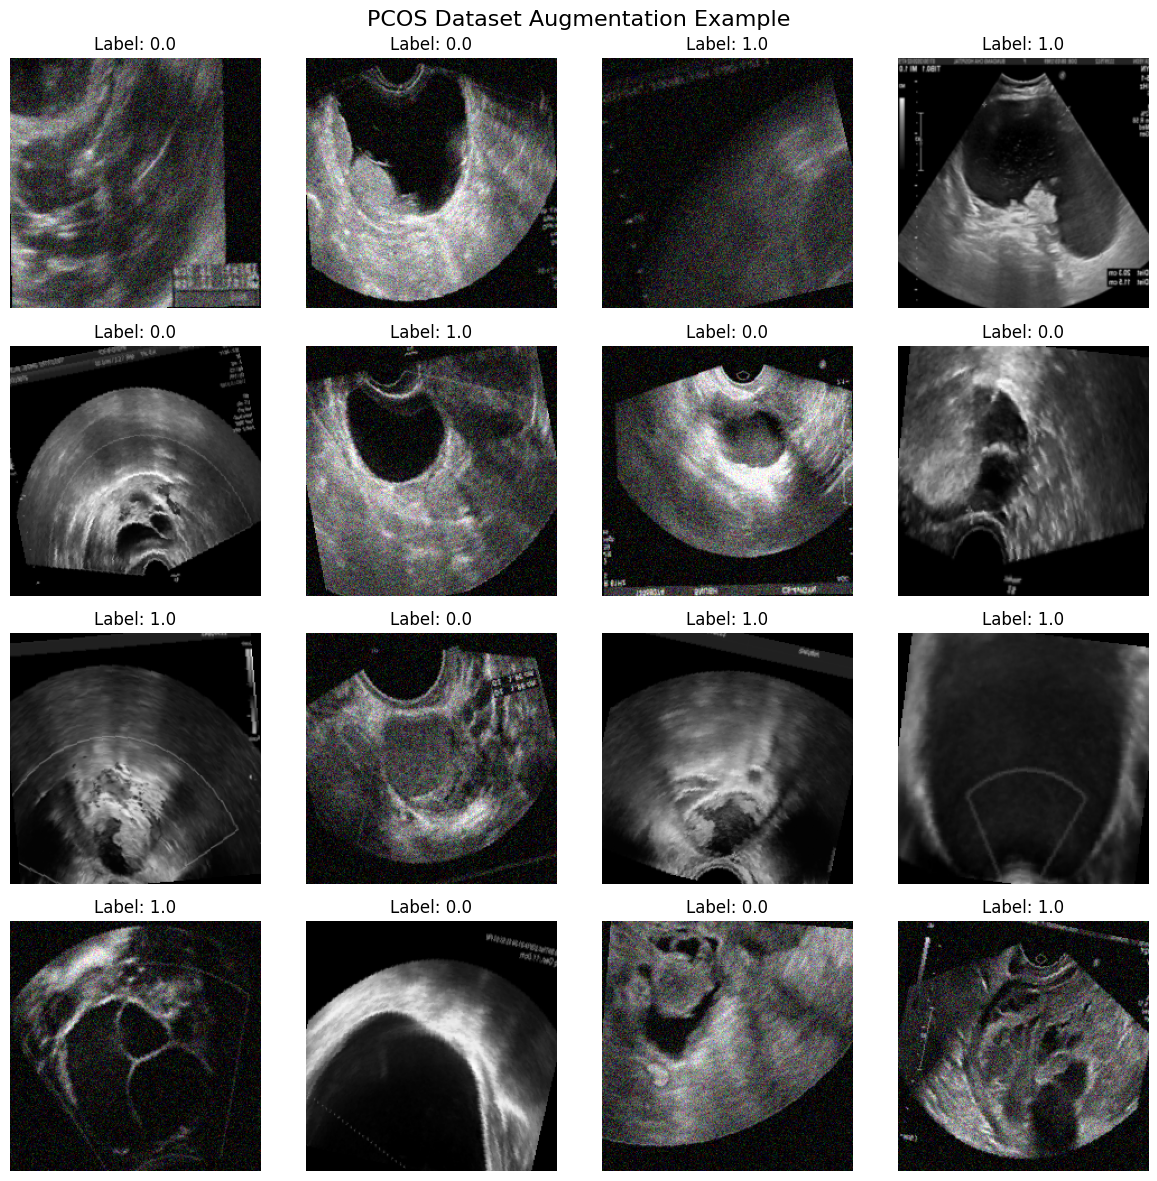

In [4]:
from torch.utils.data import DataLoader
from lib.sampler import BalancedBatchSampler
train_bs = 72
valid_bs = 24

#%% Sampler Use
                    #     sampler = BalancedBatchSampler(dataset = train_dataset, 
                    #     labels = train_dataset.labels, 
                    #     batch_size = train_bs
                    # ))
# Sampler Not Use
train_loader = DataLoader(train_dataset, batch_size = train_bs, shuffle = True, pin_memory=True, pin_memory_device= "cuda:0", persistent_workers=True, prefetch_factor = 4, num_workers= 8, )

valid_loader = DataLoader(valid_dataset, batch_size = valid_bs, shuffle = False, pin_memory=True, pin_memory_device= "cuda:0", persistent_workers=True, prefetch_factor = 4, num_workers= 8, )

#%% Test Augmentation 
X, y = next(iter(train_loader))
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize = (12, 12))
fig.suptitle('PCOS Dataset Augmentation Example', fontsize = 16)
for i in range(16):
    axes[i//4, i%4].imshow(X[i].cpu().permute(1, 2, 0).numpy())
    axes[i//4, i%4].set_title(f'Label: {y[i].item()}')
    axes[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()

# Model Load

In [5]:
import torch 
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = 'cuda'
print(f"Using {device} device")

Using cuda device


In [6]:
# torch model
# from model.loader import model_Loader
# model = model_Loader(model_name = 'convnext', num_classes = 3, type = 'l').to(device) #

from torchvision import models
import torch.nn as nn
# resnet
# model = models.resnet18(weights='IMAGENET1K_V1')
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 3)
# model = model.to(device)
from models import Model_Loader
num_classses = 1 if binary_use else 3
model = Model_Loader(model_name = 'dinov2' + '_' + 'vitl14', num_classes = num_classses).to('cuda')
#%% 
num_classses

Using cache found in /home/eiden/.cache/torch/hub/facebookresearch_dinov2_main
/home/eiden/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/eiden/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/eiden/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


1

In [7]:

sample = model(X.to('cuda')) # B x 3

sample.shape, sample.min(), sample.max()


(torch.Size([72]),
 tensor(-0.5439, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.5604, device='cuda:0', grad_fn=<MaxBackward1>))

#### Optimize, Loss 정의

#### [Settings] Train - Hyper Parmas 정의

In [8]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch 
import datetime
from sklearn.metrics import roc_auc_score
import json
from loss import Poly1FocalLoss, Poly1CrossEntropyLoss

In [9]:
Epoch = 100
loss_label_smoothing = 0.1
patience = 15
lr = 0.0000013301

#%% Loss 
# criterion = nn.CrossEntropyLoss(label_smoothing = loss_label_smoothing).to(device) # CE
# criterion = Poly1CrossEntropyLoss(num_classes= num_classses, reduction = 'mean').to(device) # Poly1CE
if binary_use:
    # 바이너리 분류에서는 pos_weight를 reshape하지 않고 직접 사용
    criterion = Poly1FocalLoss(
        num_classes = num_classses,
        reduction = 'mean',
        label_is_onehot = True,
        pos_weight = torch.tensor([3.]).to(device) # Poly1Focal for binary
    ).to(device)
else:
    # 다중 분류에서는 pos_weight 크기를 클래스 수에 맞게 조정
    criterion = Poly1FocalLoss(
        num_classes = num_classses, 
        reduction = 'mean', 
        label_is_onehot = False, 
        pos_weight = torch.tensor([1., 5., 5.]).to(device)
    ).to(device) # Poly1Focal

optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True) # Loss 기준
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=patience, verbose=True) # AUC 기준

/home/eiden/miniconda3/envs/cv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Training 

In [ ]:
best_val_auc = 0.0
no_improve_count = 0
exp_date= datetime.datetime.now().strftime('%y%m%d%H%M')

for epoch in range(1, Epoch + 1):
    ##############################
    # 1) Training Loop
    ##############################
    model.train()
    train_loss = 0
    train_prob = []
    train_label = []
    
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()

        # Forward
        y_res = model(X)
        loss = criterion(y_res, y)
        
        # Backprop
        loss.backward()
        optimizer.step()
        
        # 누적
        train_loss += loss.item()
        # 예측값
        if binary_use:
            prob = torch.sigmoid(y_res).detach().cpu()
        else:
            prob = F.softmax(y_res, dim=0).detach().cpu()  # shape: (B, C)
        train_prob.append(prob)
        train_label.append(y.detach().cpu())           # shape: (B,)
        
    # -- Epoch 단위로 평균 Loss 계산
    train_loss = train_loss / len(train_loader)
    
    # -- 전체 batch의 예측 결과 / 실제 라벨 붙이기
    train_pred = torch.cat(train_prob, dim=0)   # 예: shape [N]
    train_label = torch.cat(train_label, dim=0) # 예: shape [N]
    
    # -- ROC AUC 계산 (binary와 multi 모두 지원)
    train_auc = roc_auc_score(
        train_label, 
        train_pred, 
        multi_class='ovr' if not binary_use else 'raise',
        average='macro'
    )

    ##############################
    # 2) Validation Loop
    ##############################
    model.eval()
    val_loss = 0
    val_prob = []
    val_label = []
    
    with torch.no_grad():
        for X_val, y_val in valid_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            
            y_res_val = model(X_val)
            loss_val = criterion(y_res_val, y_val)
            
            val_loss += loss_val.item()
            
            if binary_use:
                val_prob.append(torch.sigmoid(y_res_val).cpu())
            else:
                val_prob.append(F.softmax(y_res_val, dim=0).cpu())
            val_label.append(y_val.cpu())
    
    val_loss /= len(valid_loader)
    
    #%% Validation AUC 계산
    val_pred = torch.cat(val_prob, dim=0)
    val_label = torch.cat(val_label, dim=0)
    
    val_auc = roc_auc_score(
        val_label,
        val_pred,
        multi_class='ovr' if not binary_use else 'raise',
        average='macro'
    )
    scheduler.step(val_auc)
    
    print(f"[Epoch {epoch}/{Epoch}] "
          f"Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

    ##############################
    # 3) Early Stopping + Model Save
    ##############################
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        no_improve_count = 0
        
        # 베스트 모델 갱신 -> 저장
        save_model_path = f"/home/eiden/eiden/PCOS-roi-classification/v2/log/{exp_date}.pth"
        # torch.save(model.state_dict(), save_model_path)
        
        # json파일도 하나 만들어서 Metric 저장
        save_json_path = f"/home/eiden/eiden/PCOS-roi-classification/v2/log/{exp_date}.json"
        # with open(save_json_path, 'w') as f:
        #     json.dump({
        #         'best_val_auc': best_val_auc,
        #         'train_auc': train_auc,
        #         'val_auc': val_auc,
        #         'exp_date': exp_date,
        #         'model_path': save_model_path
        #     }, f)
        
        print(f"  >> Best model updated! (AUC={best_val_auc:.4f}) <<")
    else:
        no_improve_count += 1
    
    # 15 epoch 동안 AUC 개선이 없으면 중단
    if no_improve_count >= patience:
        print("Early stopping triggered!")
        break

[Epoch 1/100] Train Loss: 0.3164, Train AUC: 0.5029 | Val Loss: 0.2170, Val AUC: 0.6659
  >> Best model updated! (AUC=0.6659) <<
[Epoch 2/100] Train Loss: 0.2245, Train AUC: 0.6307 | Val Loss: 0.2149, Val AUC: 0.6818
  >> Best model updated! (AUC=0.6818) <<
[Epoch 3/100] Train Loss: 0.2212, Train AUC: 0.6341 | Val Loss: 0.2122, Val AUC: 0.7051
  >> Best model updated! (AUC=0.7051) <<
[Epoch 4/100] Train Loss: 0.2148, Train AUC: 0.6606 | Val Loss: 0.2132, Val AUC: 0.7037
[Epoch 5/100] Train Loss: 0.2144, Train AUC: 0.6656 | Val Loss: 0.2214, Val AUC: 0.6929
[Epoch 6/100] Train Loss: 0.2120, Train AUC: 0.6788 | Val Loss: 0.2124, Val AUC: 0.6961
[Epoch 7/100] Train Loss: 0.2127, Train AUC: 0.6840 | Val Loss: 0.2221, Val AUC: 0.6964
[Epoch 8/100] Train Loss: 0.2137, Train AUC: 0.6735 | Val Loss: 0.2184, Val AUC: 0.6819
[Epoch 9/100] Train Loss: 0.2099, Train AUC: 0.6976 | Val Loss: 0.2095, Val AUC: 0.7022
[Epoch 10/100] Train Loss: 0.2066, Train AUC: 0.7145 | Val Loss: 0.2118, Val AUC: 0.6